## Neural synthesis, feature visualization, and DeepDream notes

This notebook introduces what we'll call here "neural synthesis," the technique of synthesizing images using an iterative process which optimizes the pixels of the image to achieve some desired state of activations in a convolutional neural network. 

The technique in its modern form dates back to around 2009 and has its origins in early attempts to visualize what features were being learned by the different layers in the network (see [Erhan et al](https://pdfs.semanticscholar.org/65d9/94fb778a8d9e0f632659fb33a082949a50d3.pdf), [Simonyan et al](https://arxiv.org/pdf/1312.6034v2.pdf), and [Mahendran & Vedaldi](https://arxiv.org/pdf/1412.0035v1.pdf)) as well as in trying to identify flaws or vulnerabilities in networks by synthesizing and feeding them adversarial examples (see [Nguyen et al](https://arxiv.org/pdf/1412.1897v4.pdf), and [Dosovitskiy & Brox](https://arxiv.org/pdf/1506.02753.pdf)). The following is an example from Simonyan et al on visualizing image classification models.

![Simonyan et al](http://yosinski.com/static/proj/deepvis_goose_ostrich.jpg)

In 2012, the technique became widely known after [Le et al](https://googleblog.blogspot.in/2012/06/using-large-scale-brain-simulations-for.html) published results of an experiment in which a deep neural network was fed millions of images, predominantly from YouTube, and unexpectedly learned a cat face detector. At that time, the network was trained for three days on 16,000 CPU cores spread over 1,000 machines!

![Le et al](https://image.slidesharecdn.com/quocle-mlconf-151113230600-lva1-app6891/95/quoc-le-software-engineer-google-at-mlconf-sf-111315-10-638.jpg?cb=1447456032)

In 2015, following the rapid proliferation of cheap GPUs, Google software engineers [Mordvintsev, Olah, and Tyka](https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html) first used it for ostensibly artistic purposes and introduced several innovations, including optimizing pixels over multiple scales (octaves), improved regularization, and most famously, using real images (photographs, paintings, etc) as input and optimizing their pixels so as to enhance whatever activations the network already detected (hence "hallucinating" or "dreaming"). They nicknamed their work "Deepdream" and released the first publicly available code for running it [in Caffe](https://github.com/google/deepdream/), which led to the technique being widely disseminated on social media, [puppyslugs](https://www.google.de/search?q=puppyslug&safe=off&tbm=isch&tbo=u&source=univ&sa=X&ved=0ahUKEwiT3aOwvtnXAhUHKFAKHXqdCBwQsAQIKQ&biw=960&bih=979) and all. Some highlights of their original work follow, with more found in [this gallery](https://photos.google.com/share/AF1QipPX0SCl7OzWilt9LnuQliattX4OUCj_8EP65_cTVnBmS1jnYgsGQAieQUc1VQWdgQ?key=aVBxWjhwSzg2RjJWLWRuVFBBZEN1d205bUdEMnhB).

![deepdream](https://2.bp.blogspot.com/-17ajatawCW4/VYITTA1NkDI/AAAAAAAAAlM/eZmy5_Uu9TQ/s640/classvis.png)
![deepdream](https://2.bp.blogspot.com/-nxPKPYA8otk/VYIWRcpjZfI/AAAAAAAAAmE/8dSuxLnSNQ4/s640/image-dream-map.png)

A number of creative innovations were further introduced by [Mike Tyka](http://www.miketyka.com) including optimizing several channels along pre-arranged masks, and using feedback loops to generate video.  Some examples of his work follow.

![deepdream](https://1.bp.blogspot.com/-XZ0i0zXOhQk/VYIXdyIL9kI/AAAAAAAAAmQ/UbA6j41w28o/s640/building-dreams.png)

This notebook builds upon the code found in [tensorflow's deepdream example](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/tutorials/deepdream). The first part of this notebook will summarize that one, including naive optimization, multiscale generation, and Laplacian normalization. The code from that notebook is lightly modified and is mostly found in the the [lapnorm.py](../notebooks/lapnorm.py) script, which is imported into this notebook. The second part of this notebook builds upon that example by showing how to combine channels and mask their gradients, warp the canvas, and generate video using a feedback loop. Here is a [gallery of examples](http://www.genekogan.com/works/neural-synth/) and a [video work](https://vimeo.com/246047871).

Before we get started, we need to make sure we have downloaded and placed the Inceptionism network in the data folder. Run the next cell if you haven't already downloaded it.

In [1]:
#Grab inception model from online and unzip it (you can skip this step if you've already downloaded the model.
!wget -P . https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip
!unzip inception5h.zip -d inception5h/
!rm inception5h.zip

--2018-08-12 16:44:09--  https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.10.16, 2607:f8b0:4006:819::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.10.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49937555 (48M) [application/zip]
Saving to: ‘./inception5h.zip’

inception5h.zip     100%[===================>]  47.62M  64.3MB/s    in 0.7s    

2018-08-12 16:44:10 (64.3 MB/s) - ‘./inception5h.zip’ saved [49937555/49937555]

Archive:  inception5h.zip
  inflating: inception5h/imagenet_comp_graph_label_strings.txt  
  inflating: inception5h/tensorflow_inception_graph.pb  
  inflating: inception5h/LICENSE     


To get started, make sure all of the folloing import statements work without error. You should get a message telling you there are 59 layers in the network and 7548 channels.

In [1]:
from __future__ import print_function
from io import BytesIO
import math, time, copy, json, os
import glob
from os import listdir
from os.path import isfile, join
from random import random
from io import BytesIO
from enum import Enum
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML
import numpy as np
import scipy.misc
import tensorflow as tf

# import everything from lapnorm.py
from lapnorm import *

/home/paperspace/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Number of layers 59
Total number of feature channels: 7548


Let's inspect the network now. The following will give us the name of all the layers in the network, as well as the number of channels they contain. We can use this as a lookup table when selecting channels.

In [2]:
for l, layer in enumerate(layers):
    layer = layer.split("/")[1]
    num_channels = T(layer).shape[3]
    print(layer, num_channels)

conv2d0_pre_relu 64
conv2d1_pre_relu 64
conv2d2_pre_relu 192
mixed3a_1x1_pre_relu 64
mixed3a_3x3_bottleneck_pre_relu 96
mixed3a_3x3_pre_relu 128
mixed3a_5x5_bottleneck_pre_relu 16
mixed3a_5x5_pre_relu 32
mixed3a_pool_reduce_pre_relu 32
mixed3b_1x1_pre_relu 128
mixed3b_3x3_bottleneck_pre_relu 128
mixed3b_3x3_pre_relu 192
mixed3b_5x5_bottleneck_pre_relu 32
mixed3b_5x5_pre_relu 96
mixed3b_pool_reduce_pre_relu 64
mixed4a_1x1_pre_relu 192
mixed4a_3x3_bottleneck_pre_relu 96
mixed4a_3x3_pre_relu 204
mixed4a_5x5_bottleneck_pre_relu 16
mixed4a_5x5_pre_relu 48
mixed4a_pool_reduce_pre_relu 64
mixed4b_1x1_pre_relu 160
mixed4b_3x3_bottleneck_pre_relu 112
mixed4b_3x3_pre_relu 224
mixed4b_5x5_bottleneck_pre_relu 24
mixed4b_5x5_pre_relu 64
mixed4b_pool_reduce_pre_relu 64
mixed4c_1x1_pre_relu 128
mixed4c_3x3_bottleneck_pre_relu 128
mixed4c_3x3_pre_relu 256
mixed4c_5x5_bottleneck_pre_relu 24
mixed4c_5x5_pre_relu 64
mixed4c_pool_reduce_pre_relu 64
mixed4d_1x1_pre_relu 112
mixed4d_3x3_bottleneck_pre_relu 

The basic idea is to take any image as input, then iteratively optimize its pixels so as to maximally activate a particular channel (feature extractor) in a trained convolutional network. We reproduce tensorflow's recipe here to read the code in detail. In `render_naive`, we take `img0` as input, then for `iter_n` steps, we calculate the gradient of the pixels with respect to our optimization objective, or in other words, the diff for all of the pixels we must add in order to make the image activate the objective. The objective we pass is a channel in one of the layers of the network, or an entire layer. Declare the function below.

In [3]:
def render_naive(t_obj, img0, iter_n=20, step=1.0):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    img = img0.copy()
    for i in range(iter_n):
        g, score = sess.run([t_grad, t_score], {t_input:img})
        # normalizing the gradient, so the same step size should work 
        g /= g.std()+1e-8         # for different layers and networks
        img += g*step
    return img


Now let's try running it. First, we initialize a 200x200 block of colored noise. We then select the layer `mixed4d_5x5_bottleneck_pre_relu` and the 20th channel in that layer as the objective, and run it through `render_naive` for 40 iterations. You can try to optimize at different layers or different channels to get a feel for how it looks.

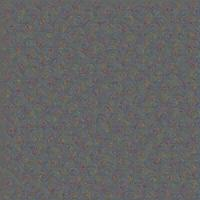

In [5]:
img0 = np.random.uniform(size=(200, 200, 3)) + 100.0
layer = 'mixed4d_3x3_bottleneck_pre_relu'
channel = 140
img1 = render_naive(T(layer)[:,:,:,channel], img0, 40, 1.0)
display_image(img1)

The above isn't so interesting yet. One improvement is to use repeated upsampling to effectively detect features at multiple scales (what we call "octaves") of the image. What we do is we start with a smaller image and calculate the gradients for that, going through the procedure like before. Then we upsample it by a particular ratio and calculate the gradients and modify the pixels of the result. We do this several times. 

You can see that `render_multiscale` is similar to `render_naive` except now the addition of the outer "octave" loop which repeatedly upsamples the image using the `resize` function.

In [4]:
def render_multiscale(t_obj, img0, iter_n=10, step=1.0, octave_n=3, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    img = img0.copy()
    for octave in range(octave_n):
        if octave>0:
            hw = np.float32(img.shape[:2])*octave_scale
            img = resize(img, np.int32(hw))
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            # normalizing the gradient, so the same step size should work 
            g /= g.std()+1e-8        # for different layers and networks
            img += g*step
        print("octave %d/%d"%(octave+1, octave_n))
    clear_output()
    return img


Let's try this on noise first. Note the new variables `octave_n` and `octave_scale` which control the parameters of the scaling. Thanks to tensorflow's patch to do the process on overlapping subrectangles, we don't have to worry about running out of memory. However, making the overall size large will mean the process takes longer to complete.

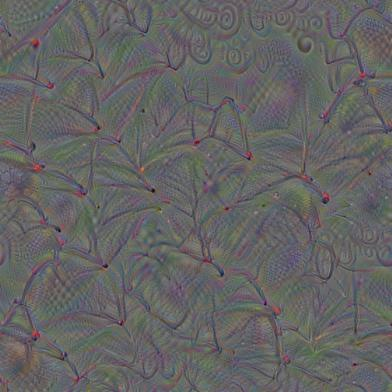

In [15]:
h, w = 200, 200
octave_n = 3
octave_scale = 1.4
iter_n = 50

img0 = np.random.uniform(size=(h, w, 3)) + 100.0

layer = 'mixed4c_5x5_bottleneck_pre_relu'
channel = 20

img1 = render_multiscale(T(layer)[:,:,:,channel], img0, iter_n, 1.0, octave_n, octave_scale)
display_image(img1)

Now load a real image and use that as the starting point. We'll use the kitty image in the assets folder. Here is the original.
<img src="../assets/kitty.jpg" alt="kitty" style="width: 280px;"/>

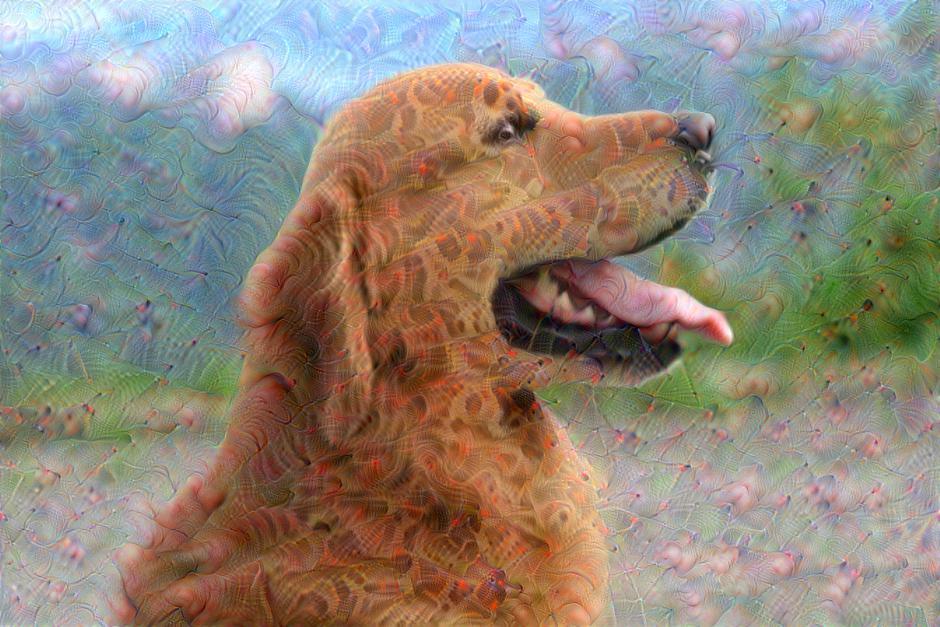

In [18]:
h, w = 320, 480
octave_n = 3
octave_scale = 1.4
iter_n = 60

img0 = load_image('../assets/kitty.jpg', h, w)

layer = 'mixed4d_5x5_bottleneck_pre_relu'
channel = 21

img1 = render_multiscale(T(layer)[:,:,:,channel], img0, iter_n, 1.0, octave_n, octave_scale)
display_image(img1)

Now we introduce Laplacian normalization. The problem is that although we are finding features at multiple scales, it seems to have a lot of unnatural high-frequency noise. We apply a [Laplacian pyramid decomposition](https://en.wikipedia.org/wiki/Pyramid_%28image_processing%29#Laplacian_pyramid) to the image as a regularization technique and calculate the pixel gradient at each scale, as before.


In [5]:
def render_lapnorm(t_obj, img0, iter_n=10, step=1.0, oct_n=3, oct_s=1.4, lap_n=4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    # build the laplacian normalization graph
    lap_norm_func = tffunc(np.float32)(partial(lap_normalize, scale_n=lap_n))
    img = img0.copy()
    for octave in range(oct_n):
        if octave>0:
            hw = np.float32(img.shape[:2])*oct_s
            img = resize(img, np.int32(hw))
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            g = lap_norm_func(g)
            img += g*step
            print('.', end='')
        print("octave %d/%d"%(octave+1, oct_n))
    clear_output()
    return img
 

With Laplacian normalization and multiple octaves, we have the core technique finished and are level with the Tensorflow example. Try running the example below and modifying some of the numbers to see how it affects the result. Remember you can use the layer lookup table at the top of this notebook to recall the different layers that are available to you. Note the differences between early (low-level) layers and later (high-level) layers.

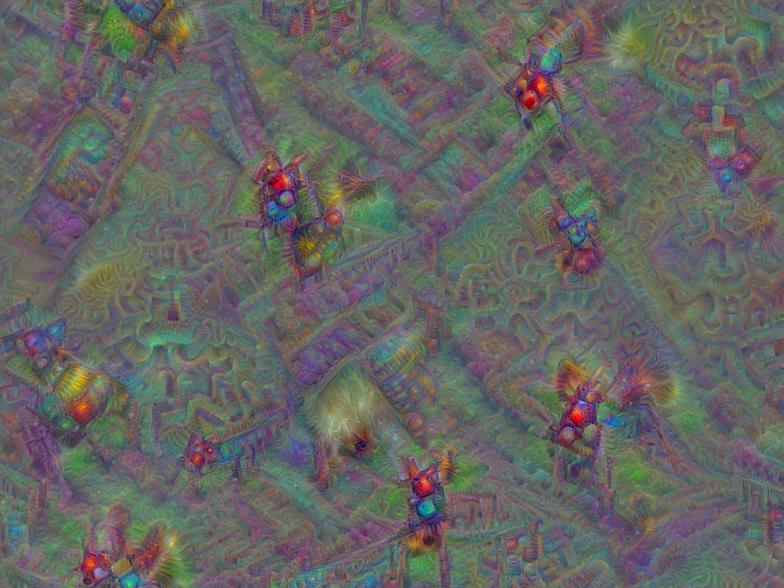

In [6]:
h, w = 300, 400
octave_n = 3
octave_scale = 1.4
iter_n = 20

img0 = np.random.uniform(size=(h, w, 3)) + 100.0

layer = 'mixed5b_pool_reduce_pre_relu'
channel = 99

img1 = render_lapnorm(T(layer)[:,:,:,channel], img0, iter_n, 1.0, octave_n, octave_scale)
display_image(img1)

Now we are going to modify the `render_lapnorm` function in three ways. 

1) Instead of passing just a single channel or layer to be optimized (the objective, `t_obj`), we can pass several in an array, letting us optimize several channels simultaneously (it must be an array even if it contains just one element).

2) We now also pass in `mask`, which is a numpy array of dimensions (`h`,`w`,`n`) where `h` and `w` are the height and width of the source image `img0` and `n` is equal to the number of objectives in `t_obj`. The mask is like a gate or multiplier of the gradient for each channel. mask[:,:,0] gets multiplied by the gradient of the first objective, mask[:,:,1] by the second and so on. It should contain a float between 0 and 1 (0 to kill the gradient, 1 to let all of it pass). Another way to think of `mask` is it's like `step` for every individual pixel for each objective.

3) Internally, we use a convenience function `get_mask_sizes` which figures out for us the size of the image and mask at every octave, so we don't have to worry about calculating this ourselves, and can just pass in an img and mask of the same size.

In [7]:
def lapnorm_multi(t_obj, img0, mask, iter_n=10, step=1.0, oct_n=3, oct_s=1.4, lap_n=4, clear=True):
    mask_sizes = get_mask_sizes(mask.shape[0:2], oct_n, oct_s)
    img0 = resize(img0, np.int32(mask_sizes[0])) 
    t_score = [tf.reduce_mean(t) for t in t_obj] # defining the optimization objective
    t_grad = [tf.gradients(t, t_input)[0] for t in t_score] # behold the power of automatic differentiation!
    # build the laplacian normalization graph
    lap_norm_func = tffunc(np.float32)(partial(lap_normalize, scale_n=lap_n))
    img = img0.copy()
    for octave in range(oct_n):
        if octave>0:
            hw = mask_sizes[octave] #np.float32(img.shape[:2])*oct_s
            img = resize(img, np.int32(hw))
        oct_mask = resize(mask, np.int32(mask_sizes[octave]))
        for i in range(iter_n):
            g_tiled = [lap_norm_func(calc_grad_tiled(img, t)) for t in t_grad]
            for g, gt in enumerate(g_tiled):
                img += gt * step * oct_mask[:,:,g].reshape((oct_mask.shape[0],oct_mask.shape[1],1))
            print('.', end='')
        print("octave %d/%d"%(octave+1, oct_n))
    if clear:
        clear_output()
    return img

Try first on noise, as before. This time, we pass in two objectives from different layers and we create a mask where the top half only lets in the first channel, and the bottom half only lets in the second.

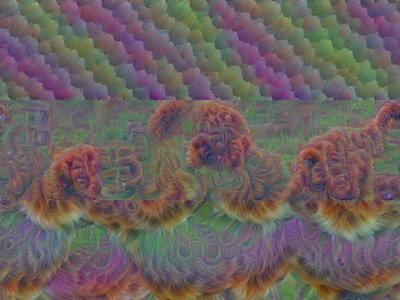

In [13]:
h, w = 300, 400
octave_n = 3
octave_scale = 1.4
iter_n = 15

img0 = np.random.uniform(size=(h, w, 3)) + 100.0

objectives = [T('mixed3a_3x3_pre_relu')[:,:,:,79], 
              T('mixed5a_1x1_pre_relu')[:,:,:,200],
              T('mixed4b_5x5_bottleneck_pre_relu')[:,:,:,22]]

# mask
mask = np.zeros((h, w, 3))
mask[0:100,:,0] = 1.0
mask[100:200,:,1] = 1.0
mask[200:,:,2] = 1.0

img1 = lapnorm_multi(objectives, img0, mask, iter_n, 1.0, octave_n, octave_scale)
display_image(img1)

Now the same thing, but we optimize over the kitty instead and pick new channels.

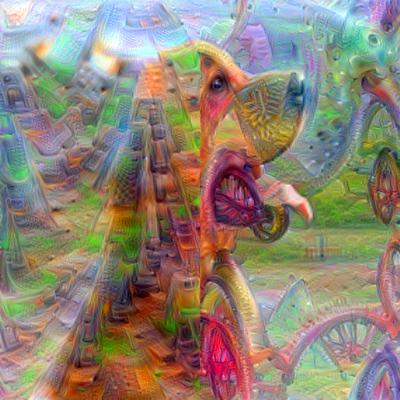

In [10]:
h, w = 400, 400
octave_n = 3
octave_scale = 1.4
iter_n = 30

img0 = load_image('../assets/kitty.jpg', h, w)

objectives = [T('mixed4d_3x3_bottleneck_pre_relu')[:,:,:,99], 
              T('mixed5a_5x5_bottleneck_pre_relu')[:,:,:,40]]

# mask
mask = np.zeros((h, w, 2))
mask[:,:200,0] = 1.0
mask[:,200:,1] = 1.0

img1 = lapnorm_multi(objectives, img0, mask, iter_n, 1.0, octave_n, octave_scale)
display_image(img1)

Let's make a more complicated mask. Here we use numpy's `linspace` function to linearly interpolate the mask between 0 and 1, going from left to right, in the first channel's mask, and the opposite for the second channel. Thus on the far left of the image, we let in only the second channel, on the far right only the first channel, and in the middle exactly 50% of each.  We'll make a long one to show the smooth transition. We'll also visualize the first channel's mask right afterwards.

image


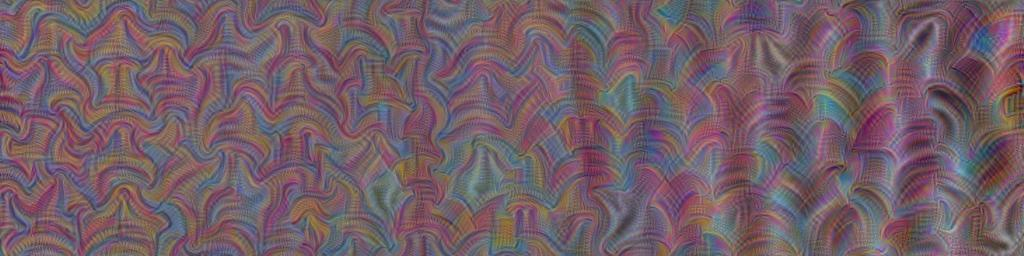

masks


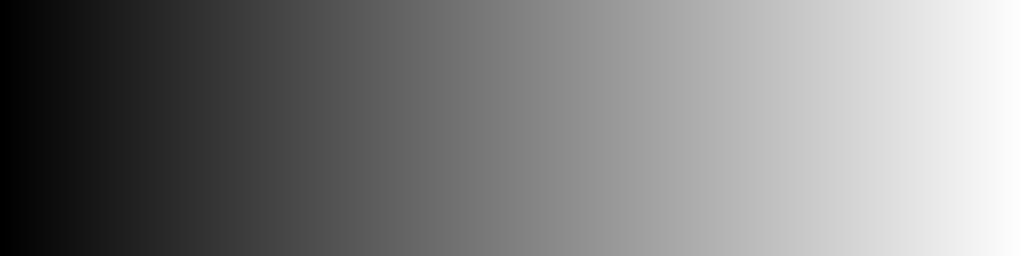

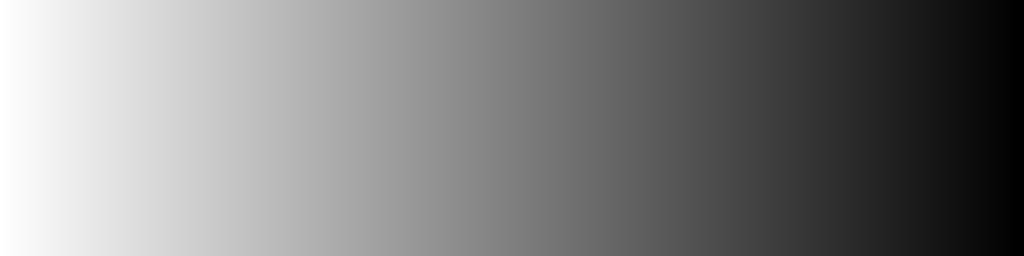

In [20]:
h, w = 256, 1024

img0 = np.random.uniform(size=(h, w, 3)) + 100.0

octave_n = 3
octave_scale = 1.4
objectives = [T('mixed4c_3x3_pre_relu')[:,:,:,50], 
              T('mixed4d_5x5_bottleneck_pre_relu')[:,:,:,29]]

mask = np.zeros((h, w, 2))
mask[:,:,0] = np.linspace(0,1,w)
mask[:,:,1] = np.linspace(1,0,w)



img1 = lapnorm_multi(objectives, img0, mask, iter_n=40, step=1.0, oct_n=3, oct_s=1.4, lap_n=4)

print("image")
display_image(img1)
print("masks")
display_image(255*mask[:,:,0])
display_image(255*mask[:,:,1])


One can think up many clever ways to make masks. Maybe they are arranged as overlapping concentric circles, or along diagonal lines, or even using [Perlin noise](https://github.com/caseman/noise) to get smooth organic-looking variation. 

Here is one example making a circular mask.

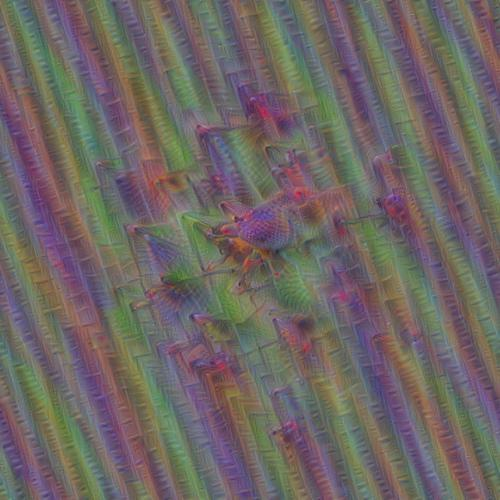

In [31]:
h, w = 500, 500

cy, cx = 0.5, 0.5

# circle masks
pts = np.array([[[i/(h-1.0),j/(w-1.0)] for j in range(w)] for i in range(h)])
ctr = np.array([[[cy, cx] for j in range(w)] for i in range(h)])

pts -= ctr
dist = (pts[:,:,0]**2 + pts[:,:,1]**2)**0.5
dist = dist / np.max(dist)

mask = np.ones((h, w, 2))
mask[:, :, 0] = dist
mask[:, :, 1] = 1.0-dist


img0 = np.random.uniform(size=(h, w, 3)) + 100.0

octave_n = 3
octave_scale = 1.4
objectives = [T('mixed3b_5x5_bottleneck_pre_relu')[:,:,:,9], 
              T('mixed4d_5x5_bottleneck_pre_relu')[:,:,:,17]]

img1 = lapnorm_multi(objectives, img0, mask, iter_n=20, step=1.0, oct_n=3, oct_s=1.4, lap_n=4)
display_image(img1)


Now we show how to use an existing image as a set of masks, using k-means clustering to segment it into several sections which become masks.

In [66]:
import sklearn.cluster

k = 3
h, w = 320, 480
img0 = load_image('../assets/kitty.jpg', h, w)

imgp = np.array(list(img0)).reshape((h*w, 3))
clusters, assign, _ = sklearn.cluster.k_means(imgp, k)
assign = assign.reshape((h, w))

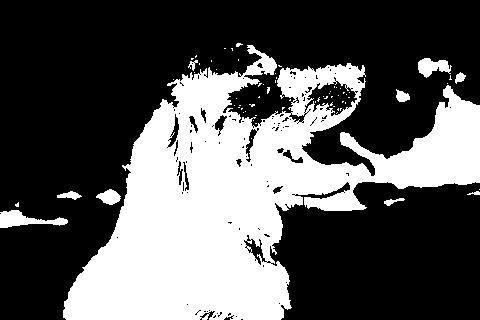

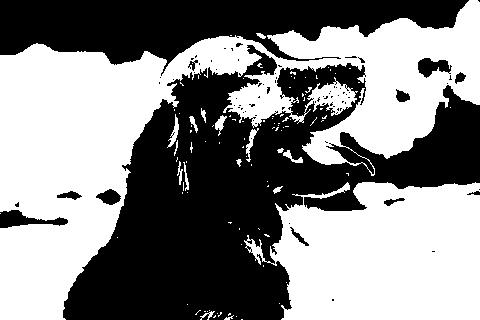

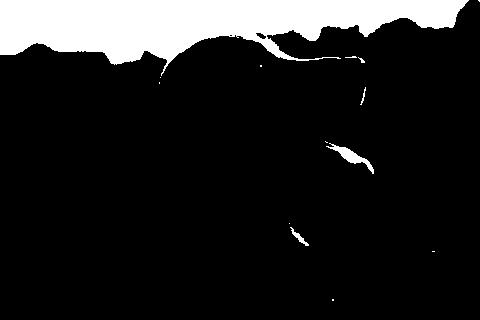

In [67]:
mask = np.zeros((h, w, k))
for i in range(k):
    mask[:,:,i] = np.multiply(np.ones((h, w)), (assign==i))

for i in range(k):
    display_image(mask[:,:,i]*255.)

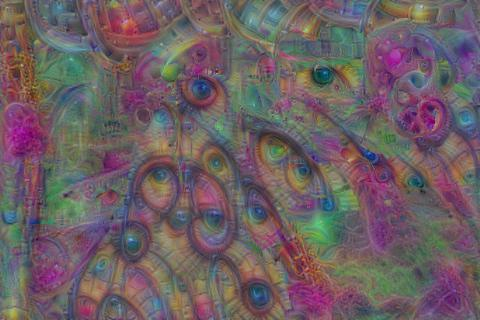

In [69]:
img0 = np.random.uniform(size=(h, w, 3)) + 100.0

octave_n = 3
octave_scale = 1.4
objectives = [T('mixed4b_3x3_bottleneck_pre_relu')[:,:,:,111], 
              T('mixed5b_pool_reduce_pre_relu')[:,:,:,12],
              T('mixed4b_5x5_bottleneck_pre_relu')[:,:,:,11]]


img1 = lapnorm_multi(objectives, img0, mask, iter_n=20, step=1.0, oct_n=3, oct_s=1.4, lap_n=4)
display_image(img1)


Now, we move on to generating video. The most straightforward way to do this is using feedback; generate one image in the conventional way, and then use it as the input to the next generation, rather than starting with noise again. By itself, this would simply repeat or intensify the features found in the first image, but we can get interesting results by perturbing the input to the second generation slightly before passing it in. For example, we can crop it slightly to remove the outer rim, then resize it to the original size and run it through again. If we do this repeatedly, we will get what looks like a constant zooming-in motion.

The next block of code demonstrates this. We'll make a small square with a single feature, then crop the outer rim by around 5% before making the next one. We'll repeat this 20 times and look at the resulting frames. For simplicity, we'll just set the mask to 1 everywhere. Note, we've also set the `clear` variable in `lapnorm_multi` to false so we can see all the images in sequence.

....................octave 1/3
....................octave 2/3
....................octave 3/3


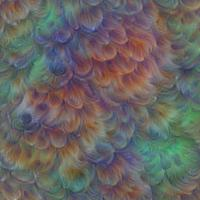

....................octave 1/3
....................octave 2/3
....................octave 3/3


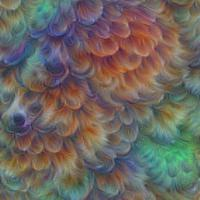

....................octave 1/3
....................octave 2/3
....................octave 3/3


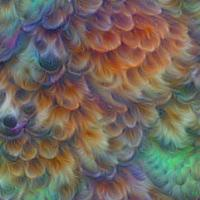

....................octave 1/3
....................octave 2/3
....................octave 3/3


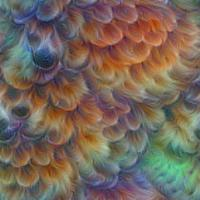

....................octave 1/3
....................octave 2/3
....................octave 3/3


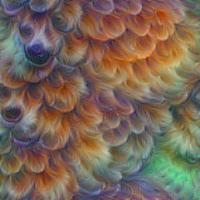

....................octave 1/3
....................octave 2/3
....................octave 3/3


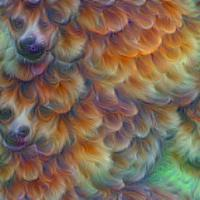

....................octave 1/3
....................octave 2/3
....................octave 3/3


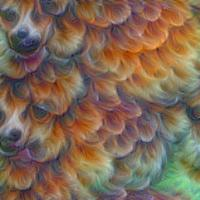

....................octave 1/3
....................octave 2/3
....................octave 3/3


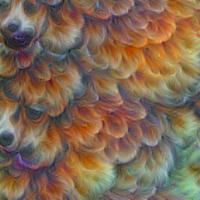

....................octave 1/3
....................octave 2/3
....................octave 3/3


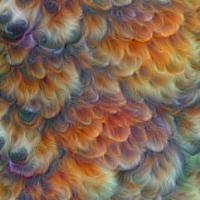

....................octave 1/3
....................octave 2/3
....................octave 3/3


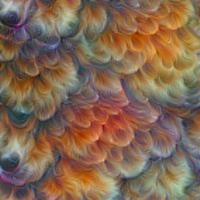

....................octave 1/3
....................octave 2/3
....................octave 3/3


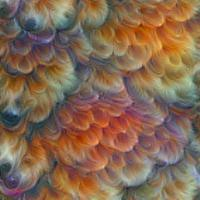

....................octave 1/3
....................octave 2/3
....................octave 3/3


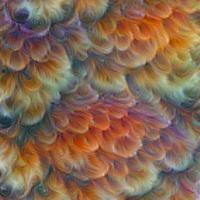

....................octave 1/3
....................octave 2/3
....................octave 3/3


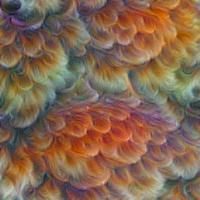

....................octave 1/3
....................octave 2/3
....................octave 3/3


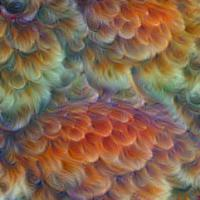

....................octave 1/3
....................octave 2/3
....................octave 3/3


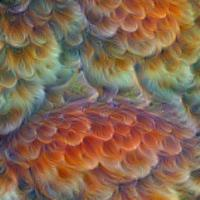

....................octave 1/3
....................octave 2/3
....................octave 3/3


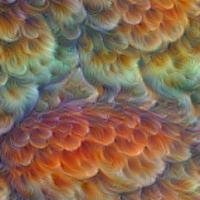

....................octave 1/3
....................octave 2/3
....................octave 3/3


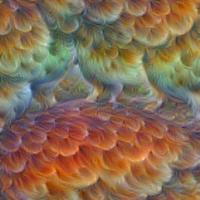

....................octave 1/3
....................octave 2/3
....................octave 3/3


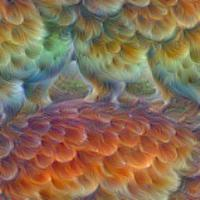

....................octave 1/3
....................octave 2/3
....................octave 3/3


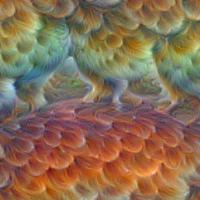

....................octave 1/3
....................octave 2/3
....................octave 3/3


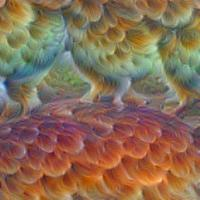

In [70]:
h, w = 200, 200

# start with random noise
img = np.random.uniform(size=(h, w, 3)) + 100.0

octave_n = 3
octave_scale = 1.4
objectives = [T('mixed4d_5x5_bottleneck_pre_relu')[:,:,:,11]]
mask = np.ones((h, w, 1))

# repeat the generation loop 20 times. notice the feedback -- we make img and then use it the initial input 
for f in range(20):
    img = lapnorm_multi(objectives, img, mask, iter_n=20, step=1.0, oct_n=3, oct_s=1.4, lap_n=4, clear=False)
    display_image(img)    # let's see it
    scipy.misc.imsave('frame%05d.png'%f, img)  # ffmpeg to save the frames
    img = resize(img[10:-10,10:-10,:], (h, w))  # before looping back, crop the border by 10 pixels, resize, repeat


If you look at all the frames, you can see the zoom-in effect. Zooming is just one of the things we can do to get interesting dynamics. Another cropping technique might be to shift the canvas in one direction, or maybe we can slightly rotate the canvas around a pivot point, or perhaps distort it with perlin noise. There are many things that can be done to get interesting and compelling results. Try also combining these with different ways of aking and modifying masks, and the combinatorial space of possibilities grows immensely. Most ambitiously, you can try training your own convolutional network from scratch and using it instead of Inception to get more custom effects. Thus as we see, the technique of feature visualization provides a wealth of possibilities to generate interesting video art. 